In [61]:
### import packages ###
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

import fsps     # governs the fundamental stellar population synthesis models
import sedpy    # contains some routines for computing projecting spectra onto filter bandpasses

from sedpy import observate

from astropy.io import fits
import astropy as ap
from astropy.cosmology import WMAP9

import astropy.coordinates as coord
from astroquery.sdss import SDSS
from astroquery import sha

sys.path.insert(0, '/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/')
import prospect     #likelihood evaluations, parameter priors, and posterior sampling

from prospect.utils.obsutils import fix_obs

import emcee
import dynesty

from prospect.models.sedmodel import SedModel
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
from prospect.models import transforms

from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.likelihood import chi_spec, chi_phot

# from prospect.plotting.figuremaker import FigureMaker

from prospect.fitting import fit_model
from prospect.io import write_results as writer
from prospect import prospect_args  # - Parser with default arguments -

import prospect.plotting.figuremaker as fmkr

### re-defining plotting defaults ###
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

%matplotlib inline

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)      #RunTimeWarnings are driving me nuts

### package versions ###
# vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
# print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))

In [62]:
start_time = time.time()

In [63]:
### My Unit Functions ###
def mJy_to_maggies(mJy):
    conversion_mJy_Jy = .001
    conversion_mJy_maggie = 3631
    return mJy * conversion_mJy_Jy/conversion_mJy_maggie

def f_nu_to_f_lambda_maggie(lam, f_nu):
    f_lambda_ergs = (10**-17 * f_nu) * (lam**2)/lightspeed
    f_lambda_mJy = (f_lambda_ergs / (1E-23)) * 1000
    f_lambda_maggie = mJy_to_maggies(f_lambda_mJy)
    return f_lambda_maggie

### Leja Functions for model_params ###
def transform_logmass_to_mass(mass=None, logmass=None, **extras):
    return 10**logmass

def load_gp(**extras):
    return None, None

def tie_gas_logz(logzsol=None, **extras):
    return logzsol

def to_dust1(dust1_fraction=None, dust1=None, dust2=None, **extras):
    return dust1_fraction*dust2

def transform_zfraction_to_sfrfraction(sfr_fraction=None, z_fraction=None, **extras):
    if sfr_fraction.size != 0:
        sfr_fraction[0] = 1-z_fraction[0]
        for i in list(range(1,sfr_fraction.shape[0])): 
            sfr_fraction[i] = np.prod(z_fraction[:i])*(1-z_fraction[i])
    return sfr_fraction

### Constants ###
lsun = 3.846e33
pc = 3.085677581467192e18 # in cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.0 * np.pi * (pc*10)**2)
jansky_mks = 1e-26


In [64]:
from prospect.sources import FastStepBasis

class FracSFH(FastStepBasis):
    
    @property
    def emline_wavelengths(self):
        return self.ssp.emline_wavelengths

    @property
    def get_nebline_luminosity(self):
        """Emission line luminosities in units of Lsun per solar mass formed"""
        return self.ssp.emline_luminosity/self.params['mass'].sum()

    def nebline_photometry(self,filters,z):
        """analytically calculate emission line contribution to photometry"""
        emlams = self.emline_wavelengths * (1+z)
        elums = self.get_nebline_luminosity # Lsun / solar mass formed
        flux = np.empty(len(filters))
        for i,filt in enumerate(filters):
            # calculate transmission at nebular emission
            trans = np.interp(emlams, filt.wavelength, filt.transmission, left=0., right=0.)
            idx = (trans > 0)
            if True in idx:
                flux[i] = (trans[idx]*emlams[idx]*elums[idx]).sum()/filt.ab_zero_counts
            else:
                flux[i] = 0.0
        return flux

    def get_galaxy_spectrum(self, **params):
        self.update(**params)

        #### here's the custom fractional stuff
        fractions = np.array(self.params['sfr_fraction'])
        bin_fractions = np.append(fractions,(1-np.sum(fractions)))
        time_per_bin = []
        for (t1, t2) in self.params['agebins']: time_per_bin.append(10**t2-10**t1)
        bin_fractions *= np.array(time_per_bin)
        bin_fractions /= bin_fractions.sum()
        
        mass = bin_fractions*self.params['mass']
        mtot = self.params['mass'].sum()

        time, sfr, tmax = self.convert_sfh(self.params['agebins'], mass)
        self.ssp.params["sfh"] = 3 #Hack to avoid rewriting the superclass
        self.ssp.set_tabular_sfh(time, sfr)
        wave, spec = self.ssp.get_spectrum(tage=tmax, peraa=False)

        return wave, spec / mtot, self.ssp.stellar_mass / mtot

    def get_spectrum(self, outwave=None, filters=None, peraa=False, **params):
        """Get a spectrum and SED for the given params.
        ripped from SSPBasis
        addition: check for flag nebeminspec. if not true,
        add emission lines directly to photometry"""

        # Spectrum in Lsun/Hz per solar mass formed, restframe
        wave, spectrum, mfrac = self.get_galaxy_spectrum(**params)

        # Redshifting + Wavelength solution
        # We do it ourselves.
        a = 1 + self.params.get('zred', 0)
        af = a
        b = 0.0

        if 'wavecal_coeffs' in self.params:
            x = wave - wave.min()
            x = 2.0 * (x / x.max()) - 1.0
            c = np.insert(self.params['wavecal_coeffs'], 0, 0)
            # assume coeeficients give shifts in km/s
            b = chebval(x, c) / (lightspeed*1e-13)

        wa, sa = wave * (a + b), spectrum * af  # Observed Frame
        if outwave is None:
            outwave = wa
        
        spec_aa = lightspeed/wa**2 * sa # convert to perAA
        # Observed frame photometry, as absolute maggies
        if filters is not None:
            mags = observate.getSED(wa, spec_aa * to_cgs, filters)
            phot = np.atleast_1d(10**(-0.4 * mags))
        else:
            phot = 0.0

        ### if we don't have emission lines, add them
        if (not self.params['nebemlineinspec']) and self.params['add_neb_emission']:
            phot += self.nebline_photometry(filters,a-1)*to_cgs

        # Spectral smoothing.
        do_smooth = (('sigma_smooth' in self.params) and
                     ('sigma_smooth' in self.reserved_params))
        if do_smooth:
            # We do it ourselves.
            smspec = self.smoothspec(wa, sa, self.params['sigma_smooth'],
                                     outwave=outwave, **self.params)
        elif outwave is not wa:
            # Just interpolate
            smspec = np.interp(outwave, wa, sa, left=0, right=0)
        else:
            # no interpolation necessary
            smspec = sa

        # Distance dimming and unit conversion
        zred = self.params.get('zred', 0.0)
        if (zred == 0) or ('lumdist' in self.params):
            # Use 10pc for the luminosity distance (or a number
            # provided in the dist key in units of Mpc)
            dfactor = (self.params.get('lumdist', 1e-5) * 1e5)**2
        else:
            lumdist = WMAP9.luminosity_distance(zred).value
            dfactor = (lumdist * 1e5)**2
        if peraa:
            # spectrum will be in erg/s/cm^2/AA
            smspec *= to_cgs / dfactor * lightspeed / outwave**2
        else:
            # Spectrum will be in maggies
            smspec *= to_cgs / dfactor / 1e3 / (3631*jansky_mks)

        # Convert from absolute maggies to apparent maggies
        phot /= dfactor

        # Mass normalization
        mass = np.sum(self.params.get('mass', 1.0))
        if np.all(self.params.get('mass_units', 'mstar') == 'mstar'):
            # Convert from current stellar mass to mass formed
            mass /= mfrac

        return smspec * mass, phot * mass, mfrac

In [65]:
### Import full galaxy file (58 galaxies) ###
AGN_file = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/asu.fit')
AGN_data = AGN_file[1].data

In [66]:
### Flux data ###
FFUV = mJy_to_maggies(AGN_data.field(4))
FNUV = mJy_to_maggies(AGN_data.field(6))
Fu = mJy_to_maggies(AGN_data.field(8))
Fg = mJy_to_maggies(AGN_data.field(10))
Fr = mJy_to_maggies(AGN_data.field(12))
Fi = mJy_to_maggies(AGN_data.field(14))
Fz = mJy_to_maggies(AGN_data.field(16))
FJ = mJy_to_maggies(AGN_data.field(18))
FH = mJy_to_maggies(AGN_data.field(20))
FKs = mJy_to_maggies(AGN_data.field(22))
F3_4 = mJy_to_maggies(AGN_data.field(24))
F4_6 = mJy_to_maggies(AGN_data.field(26))
F12 = mJy_to_maggies(AGN_data.field(28))
F22 = mJy_to_maggies(AGN_data.field(31))
F70 = mJy_to_maggies(AGN_data.field(33))
F100 = mJy_to_maggies(AGN_data.field(35))
F160 = mJy_to_maggies(AGN_data.field(37))
F250 = mJy_to_maggies(AGN_data.field(39))
F350 = mJy_to_maggies(AGN_data.field(42))
F500 = mJy_to_maggies(AGN_data.field(45))

Flux_Data = np.column_stack((FFUV, FNUV, Fu, Fg, Fr, Fi, Fz, F3_4, F4_6, F12, F22, F70, F100, F160, F250, F350, F500, FJ, FH, FKs))

### Filter uncertainty in mJy ###
FFUVe = mJy_to_maggies(AGN_data.field(5))
FNUVe = mJy_to_maggies(AGN_data.field(7))
Fue = mJy_to_maggies(AGN_data.field(9))
Fge = mJy_to_maggies(AGN_data.field(11))
Fre = mJy_to_maggies(AGN_data.field(13))
Fie = mJy_to_maggies(AGN_data.field(15))
Fze = mJy_to_maggies(AGN_data.field(17))
FJe = mJy_to_maggies(AGN_data.field(19))
FHe = mJy_to_maggies(AGN_data.field(21))
FKse = mJy_to_maggies(AGN_data.field(23))
F3_4e = mJy_to_maggies(AGN_data.field(25))
F4_6e = mJy_to_maggies(AGN_data.field(27))
F12e = mJy_to_maggies(AGN_data.field(29))
F22e = mJy_to_maggies(AGN_data.field(32))
F70e = mJy_to_maggies(AGN_data.field(34))
F100e = mJy_to_maggies(AGN_data.field(36))
F160e = mJy_to_maggies(AGN_data.field(38))
F250e = mJy_to_maggies(AGN_data.field(40))
F350e = mJy_to_maggies(AGN_data.field(43))
F500e = mJy_to_maggies(AGN_data.field(46))

In [67]:
### Choose a galaxy (0 to 57) ###
# Explorer Path = C:\Users\emma_d\ASTR_Research\Galaxy_output\G0
galaxy_num = 9
Template_Type = 'alpha_agn'

if not os.path.exists('Galaxy_output/G{}/'.format(galaxy_num)):
    os.mkdir('Galaxy_output/G{}/'.format(galaxy_num))
Galaxy_Path = 'Galaxy_output/G{}/'.format(galaxy_num)

# G_Redshift = G_Redshift_full[galaxy_num]
# ldist_Mpc = ldist_Mpc_units[galaxy_num].value
# tage_of_univ = WMAP9.age(G_Redshift).value   # Gyr

print('This is for Galaxy ', galaxy_num + 1)

ts = time.strftime("%y%b%d", time.localtime())
print('The Date is', ts)
print('The template type is', Template_Type)
# print('The redshift is ', G_Redshift)

This is for Galaxy  10
The Date is 21Jun11
The template type is alpha_agn


In [68]:
# Query SDSS to get optical spectra data
#   Used tutorial from 
#       https://learn.astropy.org/rst-tutorials/User-Defined-Model.html 
#       http://astroweb.case.edu/jakub/TA/Interpolation.html 
Gal_RA, Gal_DEC = AGN_data[galaxy_num][2], AGN_data[galaxy_num][3]
pos = coord.SkyCoord(Gal_RA, Gal_DEC, unit='deg',frame='icrs')
xid = SDSS.query_region(pos, spectro=True)
xid

/home/emma/.local/lib/python3.8/site-packages/astroquery/sdss/core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


<Table length=1>
       ra              dec               objid        ... run2d instrument
    float64          float64             int64        ... int64   bytes4  
---------------- ---------------- ------------------- ... ----- ----------
128.640444886927 17.3462034066771 1237667211043274794 ...    26       SDSS

In [69]:
### Redshift ###
G_Redshift = xid['z'][0]                # Redefine redshift from SDSS

cosmo = ap.cosmology.FlatLambdaCDM(H0=70, Om0=0.3)              # cosmological redshift object
ldist_Mpc_units = cosmo.comoving_distance(G_Redshift)           # cosmological redshift

ldist_Mpc = ldist_Mpc_units.value
tage_of_univ = WMAP9.age(G_Redshift).value   # Gyr

In [70]:
optical_spectrum = SDSS.get_spectra(plate= xid['plate'][0], fiberID= xid['fiberID'][0], mjd= xid['mjd'][0])[0]

optical_spectrum[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                 3840 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'flux    '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'loglam  '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'ivar    '        

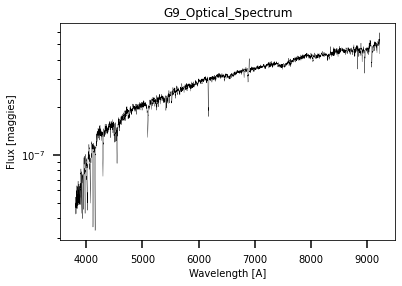

In [71]:

optical_spectrum_flux = optical_spectrum[1].data['flux']
optical_spectrum_lam = 10 ** (optical_spectrum[1].data['loglam'])

units_flux = optical_spectrum[0].header['bunit']
# print(units_flux)
units_wavelength_full = optical_spectrum[0].header['WAT1_001']
units_wavelength = units_wavelength_full[36:]

plt.plot(optical_spectrum_lam, f_nu_to_f_lambda_maggie(optical_spectrum_lam, optical_spectrum_flux), color='k', linewidth=.3)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux [maggies]')
plt.title('G{0}_Optical_Spectrum'.format(galaxy_num))
plt.yscale('log')
plt.show()

In [72]:
# irs_xid = sha.query(pos, size=0.5)

# url = irs_xid['accessUrl'][0].strip()
# img = sha.get_file(url)

# img.info()

In [73]:
# img[0].header

In [74]:
# IRS_data = img[0].data

# plt.plot(IRS_data[])



In [12]:
run_params = { 'ldist': ldist_Mpc,
                'agelims': [0.0,8.0,8.5,9.0,9.5,9.8,10.0],
                'object_redshift': G_Redshift,
                'zcontinuous': 1,                           # Leja: 2
                'verbose': False,                           # Lega: True
                'dynesty': False,                           # Change in code
                'emcee': False,                             # Change in code
                'optimize': False,                          # Change in code
                'optimization': False,
                'min_method': 'lm',
                'nmin': 5,                                  # initially 2, can try 1
                'nwalkers': 128,                            # Leja: 620
                'niter': 512,                               # Leja: 7500
                'nburn': [16, 32, 64],                      # Leja: [150, 200, 200]
                'optimization': False,
                'nested_method': 'rwalk',
                'nlive_init': 400,
                'nlive_batch': 200,
                'nested_dlogz_init': 0.05,
                'nested_posterior_thresh': 0.05,
                'nested_maxcall': int(1e7),

                # From Leja:
                'objname': 'G{0}_{1}'.format(galaxy_num, Template_Type),
                'initial_disp': 0.1

                # 'nofork': True,
                # 'ftol': 0.5e-5
                # 'maxfev': 5000,
                # 'interval': 0.2,
                # 'convergence_check_interval': 50,
                # 'convergence_chunks': 325,
                # 'convergence_kl_threshold': 0.016,
                # 'convergence_stable_points_criteria': 8, 
                # 'convergence_nhist': 50,
                # 'compute_vega_mags': False,
                # 'interp_type': 'logarithmic',
                }

In [13]:
### Build a dictionary of observational data to use in fit ###
def build_obs( **extras):
    obs = {}

    # Filters (same order as photometric data) ###
    galex = ['galex_FUV', 'galex_NUV']
    galex_unc = FFUVe, FNUVe

    sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
    sdss_unc = Fue, Fge, Fre, Fie, Fze

    allWise = ['wise_w{0}'.format(b) for b in ['1','2','3','4']]
    allWise_unc = F3_4e, F4_6e, F12e, F22e

    herschel_pacs = ['herschel_pacs_{0}'.format(b) for b in ['70','100','160']]
    herschel_pacs_unc = F70e, F100e, F160e

    herschel_spire = ['herschel_spire_{0}'.format(b) for b in ['250','350','500']]
    herschel_spire_unc = F250e, F350e, F500e

    twomass = ['twomass_{0}'.format(b) for b in ['H','J','Ks']]          #Turned off 2mass
    twomass_unc = FHe, FJe, FKse

    filternames = galex + sdss + allWise + herschel_pacs + herschel_spire + twomass
    obs["filters"] = sedpy.observate.load_filters(filternames)

    # Flux data (in same order as filters) in maggies ###
    obs["maggies"] = Flux_Data[galaxy_num]

    # Uncertainties (same order as filters) in maggies ### 
    uncertainty_cols = galex_unc, sdss_unc, allWise_unc, herschel_pacs_unc, herschel_spire_unc , twomass_unc

    maggies_uncertainy = np.vstack(uncertainty_cols).T      #transposed to get the row data not the column data
    obs["maggies_unc"] = maggies_uncertainy[galaxy_num]

    obs["phot_mask"] = np.full((len(Flux_Data[galaxy_num])), True, dtype=bool)

    ### Array of effective wavelengths for each filter (not necessary, but can be useful for plotting) ###
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    obs["wavelength"] = None    # vector of vaccum λs in angstroms
    obs["spectrum"] = None      # in maggies
    obs['unc'] = None           # spectral uncertainties
    obs['mask'] = None

    obs = fix_obs(obs)      # Ensures all required keys are present in the obs dictionary

    return obs

In [14]:
### Built obs dict using meta-params ###
obs = build_obs(**run_params)

# Look at the contents of the obs dictionary
# print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
# print("--------\nFilter objects:\n")
# print(obs["filters"])

In [16]:
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
# TemplateLibrary.show_contents()       # Look at all the prepackaged parameter sets
# TemplateLibrary.describe(Template_Type)  

In [17]:
agelims = run_params['agelims']
agelims[-1] = np.log10(tage_of_univ * 1e9)
agebins = np.array([agelims[:-1], agelims[1:]])
ncomp = agebins.shape[1]                              #- 1 Had to modify for array sizes to fit

tilde_alpha = np.array([ncomp - i for i in list(range(1, ncomp))])

In [18]:
### Build a prospect.models.SedModel object ###

def build_model(object_redshift = G_Redshift, tage_univ = tage_of_univ, 
    ldist = ldist_Mpc, TemplateType = Template_Type, ncomp = ncomp, agebins_init = agebins.T, 
    tilde_alpha = tilde_alpha, **extras):    

    ### Get (a copy of) the prepackaged model set dict (dict of dicts, keyed by parameter name) ###
    model_params = TemplateLibrary["alpha"]

    # From Leja's parameter files ----------------------------

    model_params['add_igm_absorption']= {'N': 1, 'isfree': False, 'init': 1,
                    'units': None,
                    'prior_function': None,
                    'prior_args': None}
                    # Absorbtion from intergalactic medium ~not that important
                    # Switch to include IGM absorption via Madau (1995). The zred parameter 
                    #   must be non-zero for this switch to have any effect. The optical 
                    #   depth can be scaled using the igm_factor parameter (FSPS)

    model_params['add_agb_dust_model'] = { 'N': 1, 'isfree': False, 'init': True,
                    'units': None,
                    'prior_function': None,
                    'prior_args': None}
                    # AGN pulsate and emit dust (adding to gal dust)
                    # Switch to turn on/off the AGB circumstellar dust model presented in 
                    #   Villaume (2014). NB: The AGB dust emission is scaled by the 
                    #   parameter agb_dust. (FSPS)

    # model_params['pmetals'] = { 'N': 1, 'isfree': False, 'init': -99,
    #                 'units': '',
    #                 'prior_function': None,
    #                 'prior_args': {'mini':-3, 'maxi':-1}}
                    # only needs if zcontinuous is 2: convolve with a metallicity 
                    #   distribution function at each age.The MDF is controlled by the 
                    #   parameter "pmetals"

    model_params['agebins'] = { 'N': ncomp, 'isfree': False, 'init': agebins_init,
                    'units': 'log(yr)',
                    'prior': None}
    
    model_params['sfr_fraction'] = {'N': ncomp - 1, 'isfree': False, 
                    'init': np.zeros(ncomp - 1)+1./ncomp,
                    'depends_on': transform_zfraction_to_sfrfraction,
                    'units': '',
                    'prior': priors.TopHat(mini=np.full(ncomp - 1, 0.0), 
                        maxi=np.full(ncomp - 1, 1.0))}
    
    model_params['z_fraction'] = {'N': ncomp - 1, 'isfree': True, 
                    'init': np.array([(i-1)/float(i) for i in range(ncomp,1,-1)]),
                    'units': '',
                    'init_disp': 0.02,
                    'prior': priors.Beta(alpha=tilde_alpha, 
                        beta=np.ones_like(tilde_alpha),mini=0.0,maxi=1.0)}
    
    model_params['imf_type'] = {'N': 1, 'isfree': False, 'init': 1, 
                    'units': None,
                    'prior_function_name': None,
                    'prior_args': None}
                    # 1  chabrier (2003) (FSPS)

    model_params['dust_type'] = {'N': 1, 'isfree': False, 'init': 4,
                    'units': 'index',
                    'prior_function_name': None,
                    'prior_args': None}
                    # Common variable deﬁning the extinction curve for dust around old stars
                    #   4: Kriek & Conroy (2013) attenuation curve (FSPS)

    model_params['dust1'] = {'N': 1, 'isfree': False, 'depends_on': to_dust1,
                    'init': 1.0,
                    'units': '',
                    'prior': priors.TopHat(mini=0.0, maxi=6.0)}
                    # Dust parameter describing the attenuation of young stellar light (FSPS)

    model_params['dust1_fraction'] = {'N': 1, 'isfree': True, 'init': 1.0,
                    'init_disp': 0.8,
                    'disp_floor': 0.8,
                    'units': '',
                    'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3)}

    model_params['dust_index'] = {'N': 1, 'isfree': True, 'init': 0.0,
                    'init_disp': 0.25,
                    'disp_floor': 0.15,
                    'units': '',
                    'prior': priors.TopHat(mini=-2.2, maxi=0.4)}
                    # Not needed because dust_type is 4
                    # Power law index of attenuation curve. Only used when dust_type=0 (FSPS)

    model_params['dust1_index'] = {'N': 1, 'isfree': False, 'init': -1.0,
                    'units': '',
                    'prior': priors.TopHat(mini=-1.5, maxi=-0.5)}
                    # Power law index of the attenuation curve affecting stars younger than 
                    #   dust_tesc corresponding to dust1 (FSPS)

    model_params['dust_tesc'] = {'N': 1, 'isfree': False, 'init': 7.0,
                    'units': 'log(Gyr)',
                    'prior_function_name': None,
                    'prior_args': None }
                    # Stars younger than dust_tesc are attenuated by both dust1 and dust2, 
                    #   while stars older are attenuated by dust2 only (FSPS)
    
    model_params['add_dust_emission']= {'N': 1, 'isfree': False, 'init': 1,
                    'units': None,
                    'prior_function': None,
                    'prior_args': None}
                    # Switch to turn on/off the Draine & Li 2007 dust emission model (FSPS)

    model_params['duste_gamma'] = {'N': 1, 'isfree': True, 'init': 0.01,
                    'init_disp': 0.4,
                    'disp_floor': 0.3,
                    'units': None,
                    'prior': priors.TopHat(mini=0.0, maxi=1.0)}
                    # Parameter of the Draine & Li (2007) dust emission model. Specifies 
                    #   the relative contribution of dust heated at a radiation field 
                    #   strength of Umin and dust heated at Umin < U <= Umax (FSPS)

    model_params['duste_umin'] = {'N': 1, 'isfree': True, 'init': 1.0,
                    'init_disp': 10.0,
                    'disp_floor': 5.0,
                    'units': None,
                    'prior': priors.TopHat(mini=0.1, maxi=25.0)}
                    # Parameter of the Draine & Li (2007) dust emission model. Specifies 
                    #   the minimum radiation field strength in units of the MW value (FSPS)

    model_params['duste_qpah']= {'N': 1, 'isfree': True, 'init': 3.0,
                    'init_disp': 3.0,
                    'disp_floor': 3.0,
                    'units': 'percent',
                    'prior': priors.TopHat(mini=0.0, maxi=10.0)}
                    # Make bumps in mid
                    # Parameter of Draine & Li (2007) dust emission model. Specifies grain
                    #   size distribution through the fraction of grain mass in PAHs (FSPS)

    model_params['add_neb_emission'] = {'N': 1, 'isfree': False, 'init': True,
                    'units': r'log Z/Z_\odot',
                    'prior_function_name': None,
                    'prior_args': None}
                    # Switch to turn on/off a nebular emission model (both continuum and
                    #   line emission), based on Cloudy models from Nell Byler. Contrary 
                    #   to FSPS, this option is turned off by default (FSPS)
    
    model_params['add_neb_continuum']= {'N': 1, 'isfree': False, 'init': True,
                    'units': r'log Z/Z_\odot',
                    'prior_function_name': None,
                    'prior_args': None}
                    # Not needed: Turns off automatically because add_neb_emission is on
                    # Switch to turn on/off the nebular continuum component (FSPS)

    model_params['nebemlineinspec'] = {'N': 1, 'isfree': False, 'init': False,
                    'prior_function_name': None,
                    'prior_args': None}
                    # Flag to include the emission line fluxes in the spectrum. Turning 
                    #   this off is a significant speedup in model calculation time. If 
                    #   not set, the line luminosities are still computed (FSPS)
    
    model_params['gas_logz'] = {'N': 1, 'isfree': False, 'init': 0.0,
                    'depends_on': tie_gas_logz,
                    'units': r'log Z/Z_\odot',
                    'prior': priors.TopHat(mini=-2.0, maxi=0.5)}
                    # Sharp lines above optical
                    # Log of the gas-phase metallicity; relevant only for the 
                    #   nebular emission model (FSPS)
    
    model_params['gas_logu'] = {'N': 1, 'isfree': False, 'init': -2.0,
                    'units': '',
                    'prior': priors.TopHat(mini=-4.0, maxi=-1.0)}
                    # Log of the gas ionization parameter; relevant only 
                    #   for the nebular emission model (FSPS)
    

    ######### AGN PARAMETERS ###############################################
    model_params['add_agn_dust'] = {'N': 1, 'isfree': False, 'init': True,
                    'units': '',
                    'prior_function_name': None,
                    'prior_args': None}
    
    model_params['fagn'] = {'N': 1, 'isfree': True, 'init': 0.05,
                    'init_disp': 0.05,
                    'disp_floor': 0.01,
                    'units': '',
                    'prior': priors.LogUniform(mini=0.000316228, maxi=3.0)}
    
    model_params['agn_tau'] = {'N': 1, 'isfree': True, 'init': 10.0,
                    'init_disp': 10,
                    'disp_floor': 2,
                    'units': '',
                    'prior': priors.LogUniform(mini=5.0, maxi=150.0)}
    ########################################################################


    # ----------------------------------------------------------------
    # Unit Parameters (Leja)
    model_params['peraa'] = {'N': 1, 'isfree': False, 
                    'init': False}
                    # True: return the spectrum in L_sun/A. Else, return 
                    #   the spectrum in the FSPS standard L_sun/Hz (FSPS)
    model_params['mass_units'] = {'N': 1, 'isfree': False, 'init': 'mformed'}
    # ----------------------------------------------------------------

    # Original Parameters #

    model_params['logzsol'] =  { 'N': 1, 'isfree': True, 'init': -0.5,
                    'init_disp': 0.25,
                    'disp_floor': 0.2,
                    'units': r'$\log (Z/Z_\odot)$',
                    'prior': priors.TopHat(mini=-1.98, maxi=0.19)}
                    # Parameter describing the metallicity (FSPS)

    model_params['sfh'] = {'init': 4 }
                    # Defines the type of star formation history, normalized such 
                    #   that one solar mass of stars is formed over the full SFH (FSPS)
    model_params["zred"] = {'init': object_redshift }
                    # Redshift
                    #  If this value is non-zero and if redshift_colors=1, the 
                    #   magnitudes will be computed for the spectrum placed at redshift 
                    #   zred (FSPS)

    model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, 
                    "units":"Mpc"} 

    model_params['logmass'] = {'N': 1, 'isfree': True, 'init': 10.0,
                    'units': 'Msun',
                    'prior': priors.TopHat(mini=5.0, maxi=13.0)}

    model_params['mass'] = { 'N': 1, 'isfree': False, 'init': 1e10, 
                    'units': 'Msun',
                    'depends_on' : transform_logmass_to_mass,
                    'prior': priors.TopHat(mini=1e5, maxi=1e13)}    

    model_params['dust2'] = {'N': 1, 'isfree': True, 'init': 0.3,
                    'init_disp': 0.25,
                    'disp_floor': 0.15,
                    'units': '',
                    'prior': priors.TopHat(mini=0, maxi=4.0)}
                    # Dust parameter describing the attenuation of old stellar light, 
                    #   i.e. where t > dust_tesc (see Conroy et al. 2009a) (FSPS)

    # From Leja
    fit_order = ['logmass', 'z_fraction', 'dust2', 'logzsol', 'dust_index', 
                    'dust1_fraction', 'duste_qpah', 'duste_gamma', 'duste_umin'] # add AGN to end

    parnames = {k: model_params[k] for k in fit_order}
    # print(parnames)
    tparams = parnames
    for param in model_params:
        # print(param)
        if param not in fit_order:
            tparams[param] = model_params[param]
    # print(tparams)
    model = SedModel(model_params)

    return model

In [19]:
### Build model and view model ###
model = build_model(**run_params)
# print(model)
# print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
# print("Initial parameter dictionary:\n{}".format(model.params))

In [20]:
def build_sps(zcontinuous=1, **extras):
    from prospect.sources.ssp_basis import FastStepBasis
    sps = FracSFH(zcontinuous = 1, **extras)         # run_params
    return sps

In [21]:
sps = build_sps(**run_params)

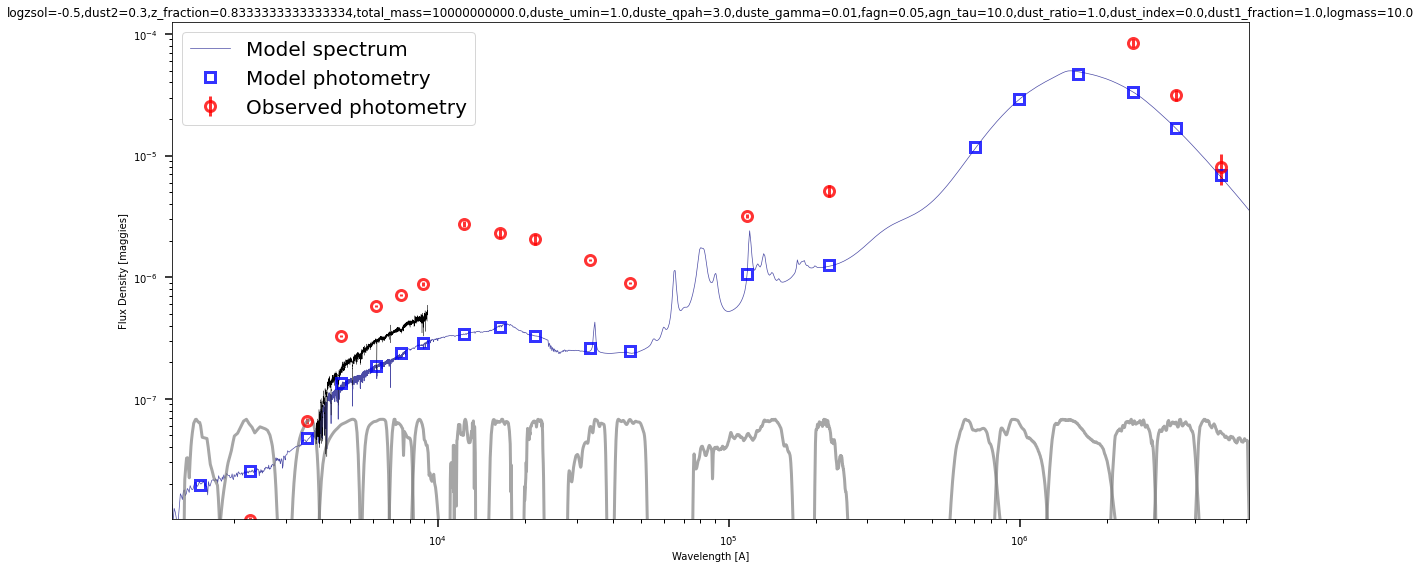

In [22]:
### View Model ###
### prediction for the data from any set of model params

### Generate the model SED at the initial value of theta ###
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
wphot = obs["phot_wave"]    # photometric effective wavelengths
if obs["wavelength"] is None:
    # spectroscopic wavelengths
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a              # redshift them
else:
    wspec = obs["wavelength"]

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

plt.plot(optical_spectrum_lam, f_nu_to_f_lambda_maggie(optical_spectrum_lam, optical_spectrum_flux), color='k', linewidth=.3)

savefig(Galaxy_Path + 'G{0}_{1}_{2}_SED_plot_2'.format(galaxy_num, Template_Type, ts))


In [23]:
### Likelyhood Function ###
"""
For nested sampling lnprobfn(theta, nested=True) will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling lnprobfn(theta, nested=False) returns the posterior probability.
"""

### Running Prospector ###
# Fit the model using chi squared minimization
# Ensemble MCMC sampler around best location from the minimization 
# Dynamic nested sampling with dynesty

# Here we will run all our building functions
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to 
# know which stellar isochrone and spectral library
# print(sps.ssp.libraries)
# help(fit_model)

In [24]:
### Minimization ###
# Uses Levenberg-Marquardt, needed parameters in run_params
# requires a likelihood function that returns a vector of chi values
# imported lnprobfn function takes care of chi values to likelyhood

# --- start minimization ---- # 
run_params["emcee"] = False
run_params["optimize"] = True

output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)
Done optmization in 135.3971951007843s


model.theta [-5.00000000e-01  3.00000000e-01  8.33333333e-01  8.00000000e-01
  7.50000000e-01  6.66666667e-01  5.00000000e-01  1.00000000e+10
  1.00000000e+00  3.00000000e+00  1.00000000e-02  5.00000000e-02
  1.00000000e+01  1.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+01]
ind_best =  0
theta_best =  [-5.00000000e-01  3.00000000e-01  8.33333333e-01  8.00000000e-01
  7.50000000e-01  6.66666667e-01  5.00000000e-01  1.00000000e+10
  1.00000000e+00  3.00000000e+00  1.00000000e-02  5.00000000e-02
  1.00000000e+01  1.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+01]


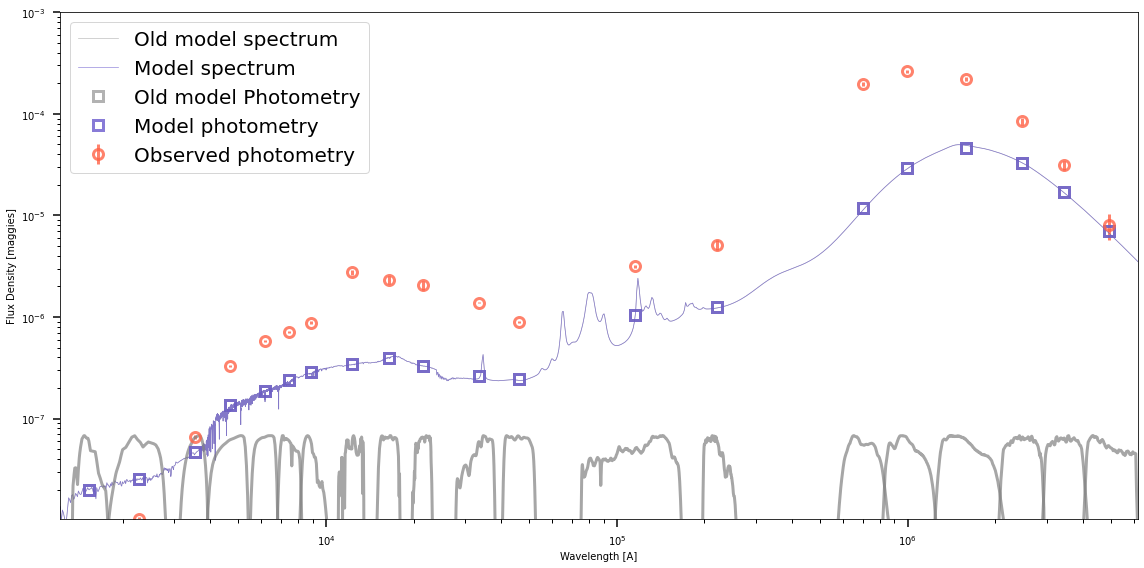

In [25]:
print("model.theta", model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print("ind_best = ", ind_best)
theta_best = results[ind_best].x.copy()
print("theta_best = ", theta_best)


# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))

# wspec * (1 + model.params['zred'])

# plot Data, best fit model, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7) 
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ymax = 10**-3
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + 'G{0}_{1}_{2}_min_model_plot_3'.format(galaxy_num, Template_Type, ts))

In [26]:
run_params["optimize"] = False
run_params["emcee"] = True

In [27]:
output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)
done emcee in 1199.0067656040192s


In [28]:
ts = time.strftime("%y%b%d", time.localtime())
hfile = Galaxy_Path + 'G{0}_{1}_{2}_mcmc.h5'.format(galaxy_num, Template_Type, ts)
obs, model, sps = build_obs(**run_params),  build_model(**run_params), build_sps(**run_params) #, build_all(**run_params)

In [29]:
### Use to save results to disk ###
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished
/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),


In [30]:
import prospect.io.read_results as reader
results_type = "emcee" 
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`

# change to file that was just generated
result, obs, __ = reader.results_from(Galaxy_Path + 'G{0}_{1}_{2}_mcmc.h5'.format(galaxy_num, Template_Type, ts), dangerous=False)

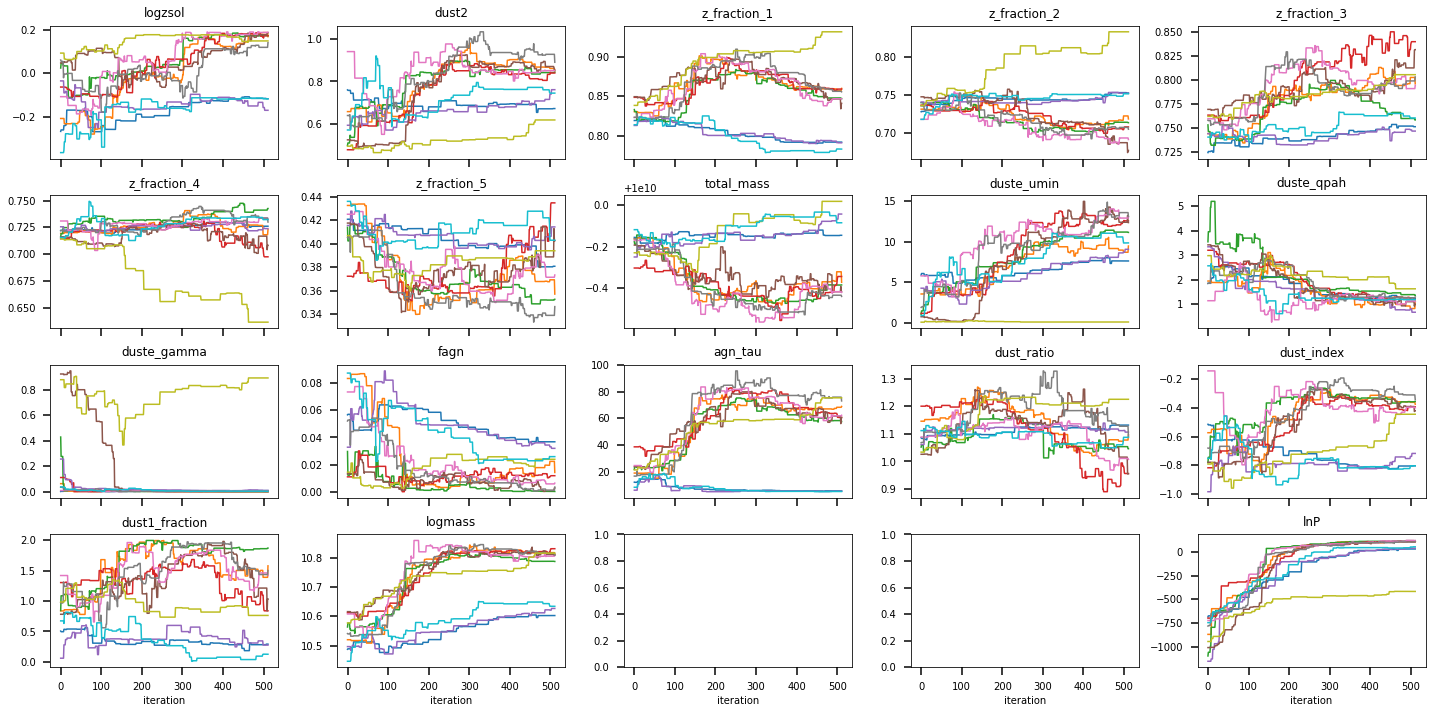

In [31]:
### Plotting Parameter Traces ###
chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)

savefig(Galaxy_Path + 'G{0}_{1}_{2}_param_trace_4'.format(galaxy_num, Template_Type, ts))

Optimization value: [-5.00000000e-01  3.00000000e-01  8.33333333e-01  8.00000000e-01
  7.50000000e-01  6.66666667e-01  5.00000000e-01  1.00000000e+10
  1.00000000e+00  3.00000000e+00  1.00000000e-02  5.00000000e-02
  1.00000000e+01  1.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+01]
MAP value: [ 1.81535645e-01  8.46064489e-01  8.43755671e-01  6.97840068e-01
  8.03405185e-01  7.18654385e-01  3.61932308e-01  1.00000000e+10
  1.24813222e+01  1.40430745e+00  1.51088805e-03  1.21515431e-03
  6.84440176e+01  1.05100997e+00 -3.77211990e-01  1.36921838e+00
  1.07963403e+01]


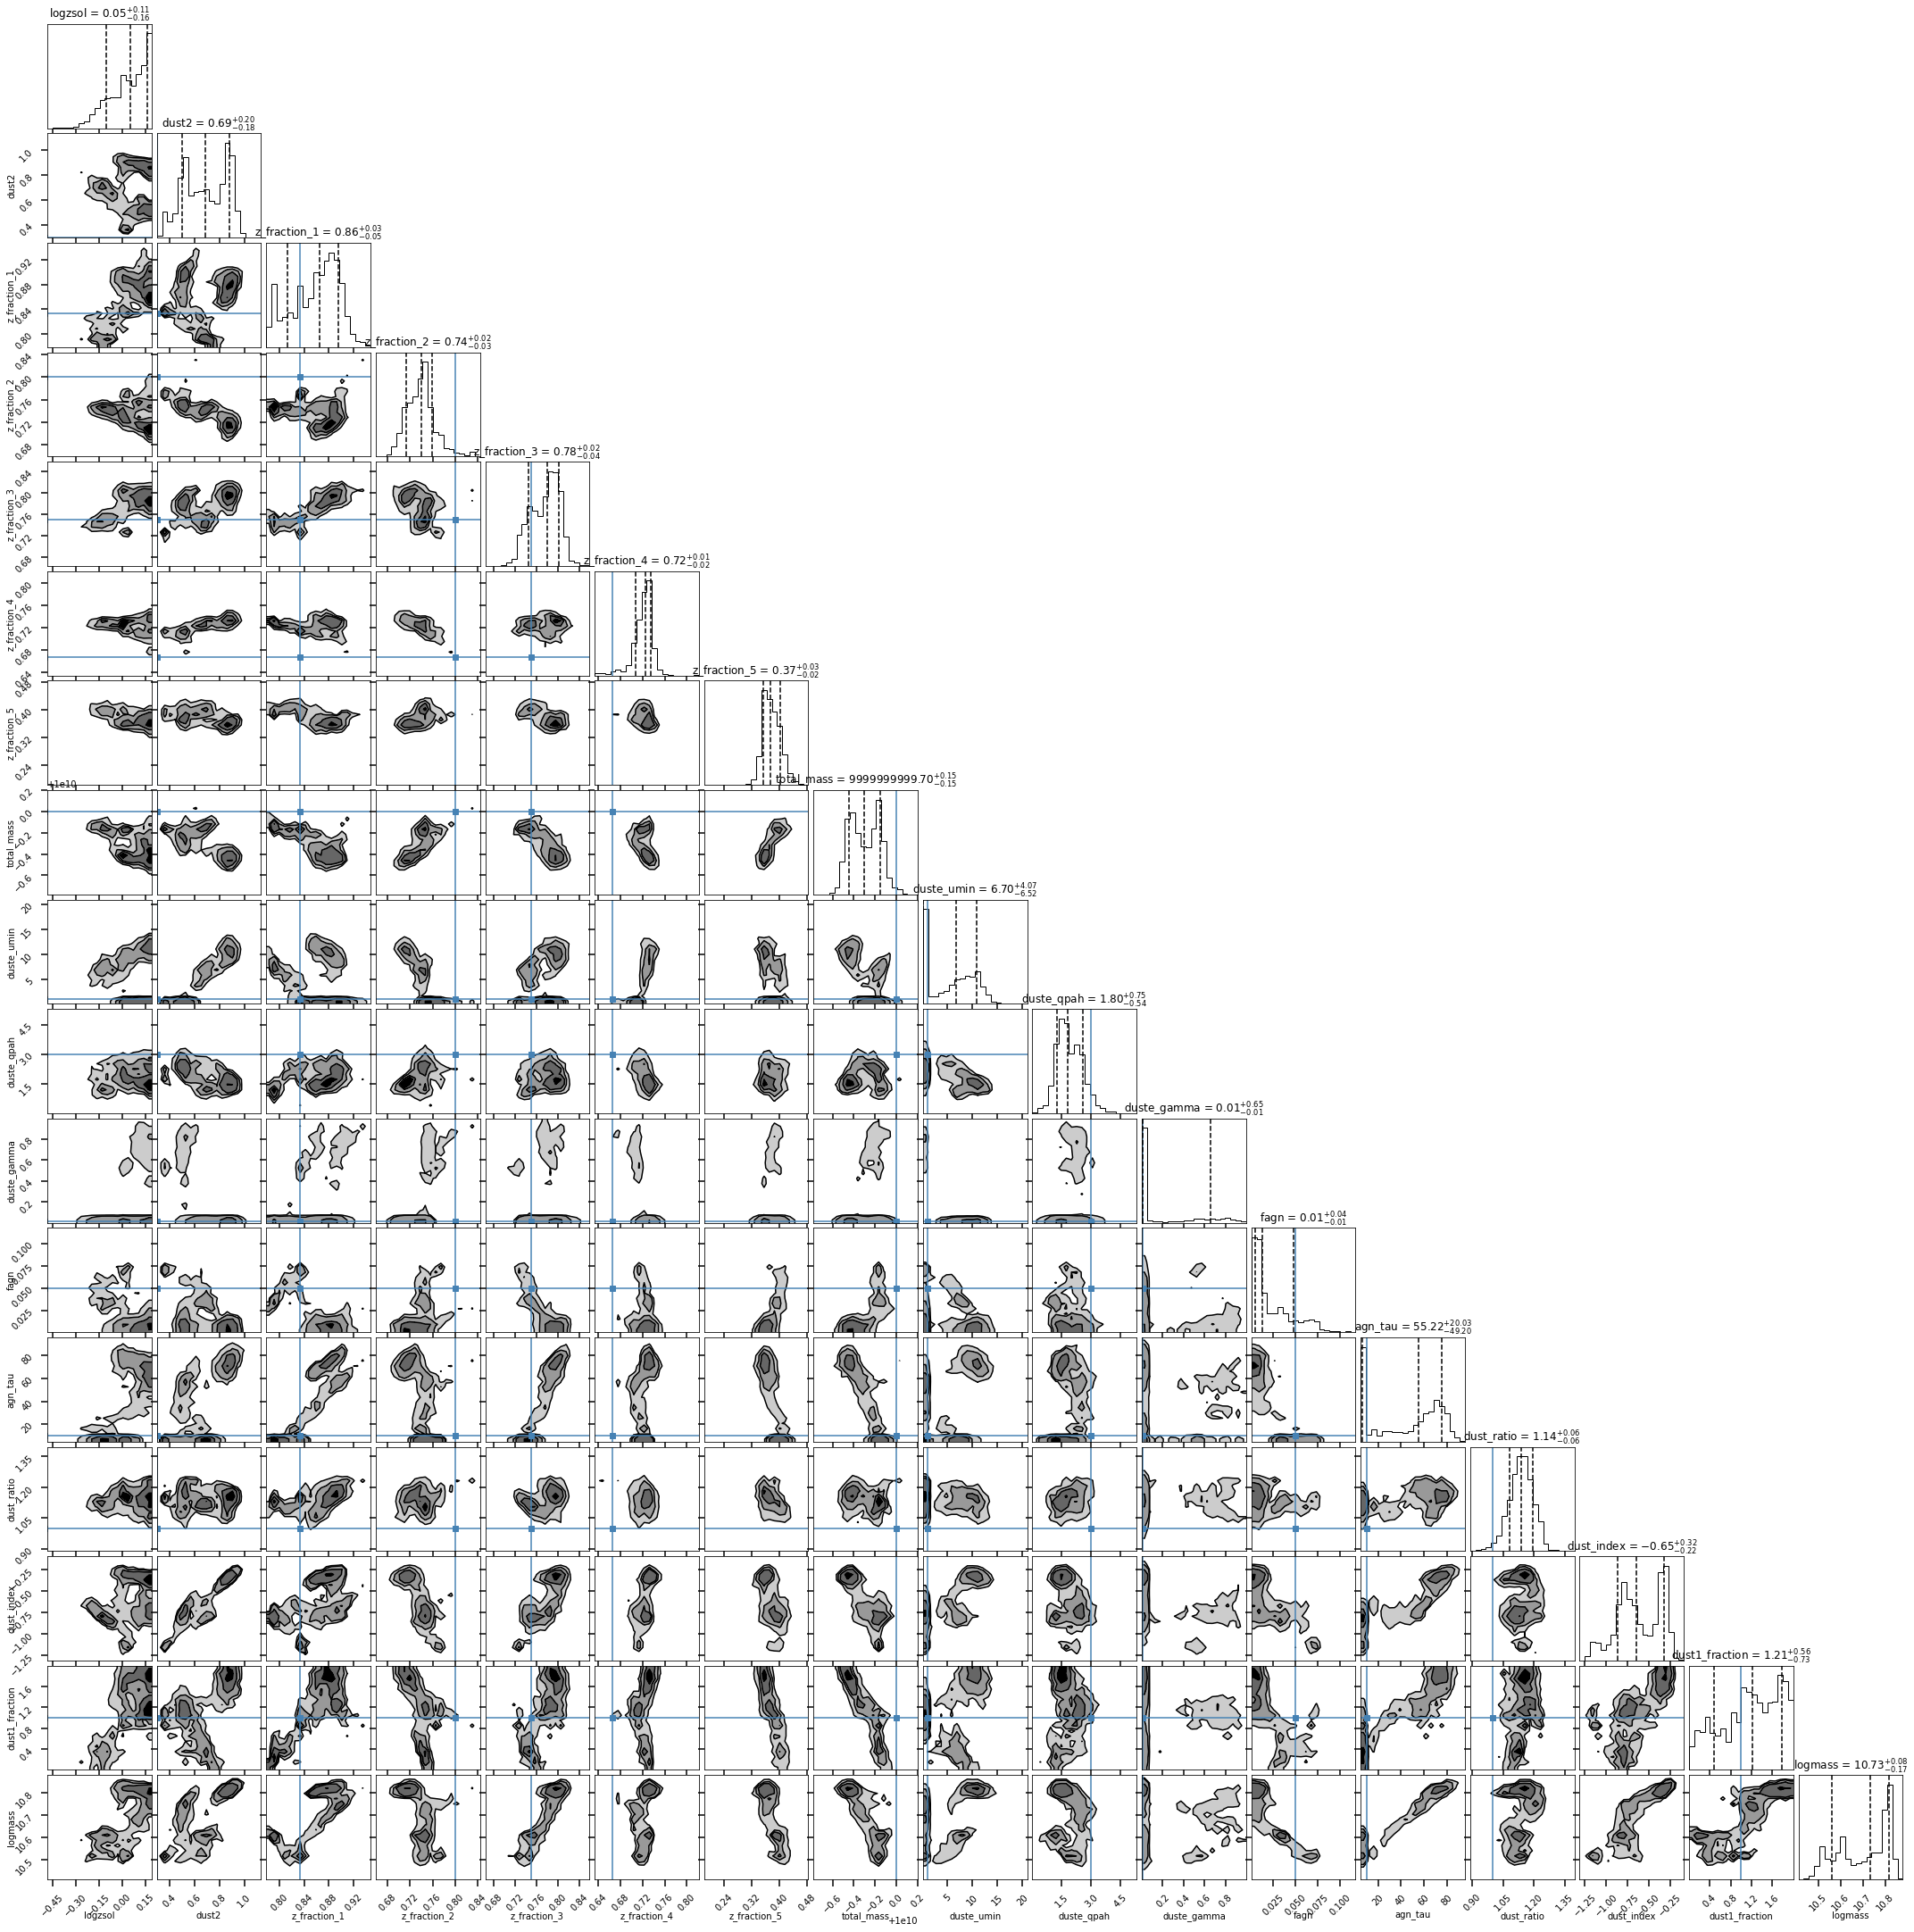

In [32]:
### Corner Plot ###
# maximum a posterior (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
i, j = np.unravel_index(imax, result['lnprobability'].shape)
theta_max = result['chain'][i, j, :].copy()
thin = 5

print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))
cornerfig = reader.subcorner(result, start=0, thin=thin,  truths= theta_best,
                             fig=subplots(17,17,figsize=(30,30))[0])       # MUST modify subplot

savefig(Galaxy_Path + 'G{0}_{1}_{2}_corner_plot_5'.format(galaxy_num, Template_Type, ts))

In [23]:
for i in range(0,len(result['theta_labels'])):
    print(result['theta_labels'][i], ':', theta_max[i], theta_best[i])

NameError: name 'result' is not defined

In [34]:
# https://github.com/nolaaa/SED_fitting_Prospecotr/blob/master/7_run_prospector_for_all_arcs.ipynb

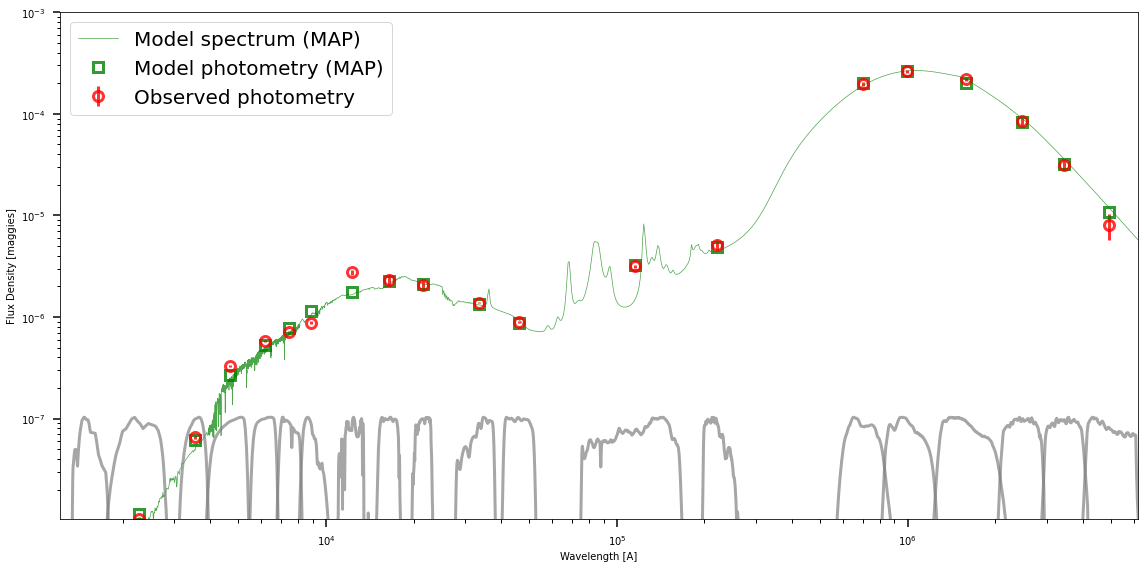

In [35]:
# https://github.com/bd-j/prospector/issues/186

mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

loglog(wspec * (1 + model.params['zred']), mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + 'G{0}_{1}_{2}_MAP_SED_6'.format(galaxy_num, Template_Type, ts))

In [36]:
end_time = time.time()
print("this program takes:", end_time - start_time, "seconds to run")
print("this program takes:", (end_time - start_time)/60, "minutes to run")

this program takes: 1540.181220293045 seconds to run
this program takes: 25.669687004884086 minutes to run


In [37]:
fmkr.FigureMaker()

In [38]:
result

{'model_params': [{'init': 0.0478377, 'name': 'zred'},
  {'N': 1,
   'isfree': False,
   'init': 10000000000.0,
   'units': 'Msun',
   'depends_on': ['transform_logmass_to_mass', '__main__'],
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G@\xf8j\x00\x00\x00\x00\x00h\x06GB\xa20\x9c\xe5@\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'name': 'mass'},
  {'N': 1,
   'isfree': True,
   'init': -0.5,
   'init_disp': 0.25,
   'disp_floor': 0.2,
   'units': '$\\log (Z/Z_\\odot)$',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G\xbf\xff\xae\x14z\xe1G\xaeh\x06G?\xc8Q\xeb\x85\x1e\xb8RuX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'name': 'logzsol